C:\Users\pc\AppData\Local\Temp\ipykernel_7384\1054860279.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  brent_df = pd.read_csv(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma1, sigma2]


Output()

Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 87 seconds.


            mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau     5388.289  21.143  5347.000  5421.000      0.504    0.377    1767.0   
mu1        0.000   0.000    -0.000     0.001      0.000    0.000   12261.0   
mu2       -0.000   0.000    -0.001     0.001      0.000    0.000   12619.0   
sigma1     0.023   0.000     0.023     0.023      0.000    0.000   11453.0   
sigma2     0.029   0.000     0.028     0.029      0.000    0.000   11441.0   

        ess_tail  r_hat  
tau       2609.0    1.0  
mu1       7778.0    1.0  
mu2       7538.0    1.0  
sigma1    7892.0    1.0  
sigma2    7637.0    1.0  


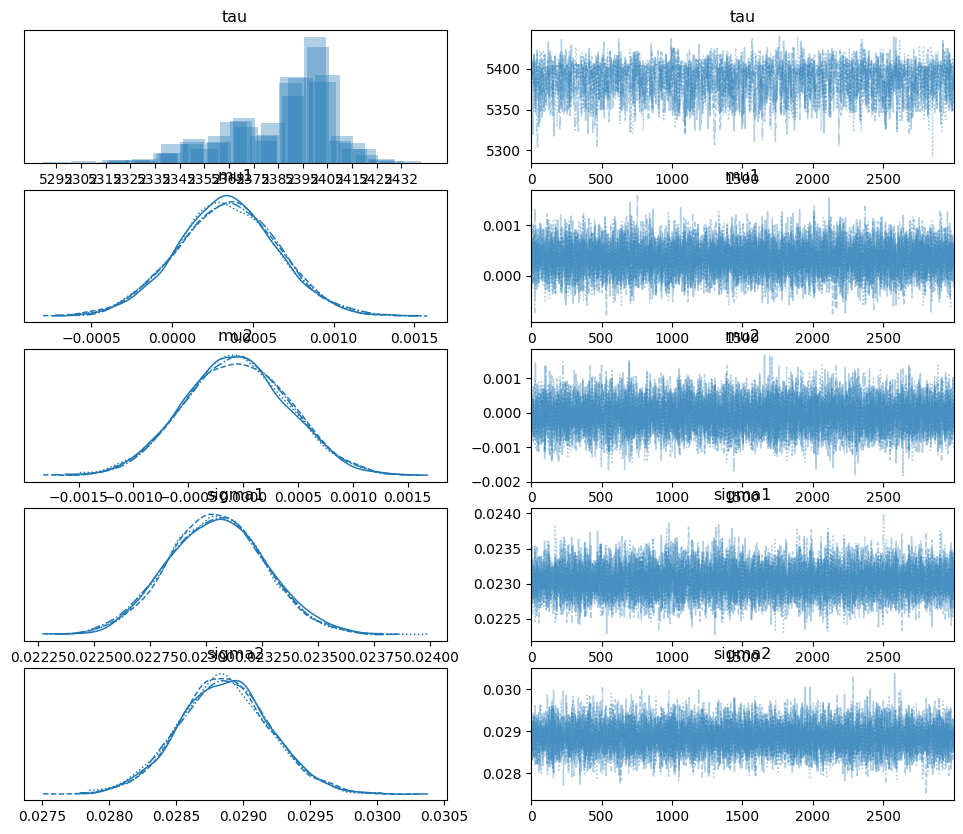

In [ ]:
import os
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm
import pytensor.tensor as at
import matplotlib.pyplot as plt

# ==============================
# 1. Load and prepare data
# ==============================
brent_df = pd.read_csv(
    "C:/Users/pc/Desktop/10 Academy/Week 10/Brentoil/data/brent_prices.csv",
    parse_dates=['Date'],
    date_parser=lambda x: pd.to_datetime(x, format='%d-%m-%Y', errors='coerce')
)

brent_df = brent_df.sort_values('Date')
brent_df['LogReturn'] = np.log(brent_df['Price']).diff()

log_returns = brent_df['LogReturn'].dropna().values
time_idx_tt = at.arange(len(log_returns))

# ==============================
# 2. Bayesian change point model
# ==============================
with pm.Model() as model:
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(log_returns) - 1)

    # Broader priors for better exploration
    mu1 = pm.Normal('mu1', mu=0, sigma=0.1)
    mu2 = pm.Normal('mu2', mu=0, sigma=0.1)

    sigma1 = pm.HalfNormal('sigma1', sigma=0.1)
    sigma2 = pm.HalfNormal('sigma2', sigma=0.1)

    mu = pm.math.switch(tau >= time_idx_tt, mu1, mu2)
    sigma = pm.math.switch(tau >= time_idx_tt, sigma1, sigma2)

    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=log_returns)

    trace = pm.sample(
        draws=3000,
        tune=2000,
        target_accept=0.99,
        init="adapt_diag",
        return_inferencedata=True
    )

# ==============================
# 3. Ensure output folder exists
# ==============================
output_dir = "outputs/model_results"
os.makedirs(output_dir, exist_ok=True)

# ==============================
# 4. Save and summarize results
# ==============================
az.to_netcdf(trace, f"{output_dir}/trace.nc")
print(az.summary(trace, var_names=['tau', 'mu1', 'mu2', 'sigma1', 'sigma2']))

# ==============================
# 5. Plot posterior traces
# ==============================
az.plot_trace(trace, var_names=['tau', 'mu1', 'mu2', 'sigma1', 'sigma2'])
plt.show()
